In [70]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pathlib import Path
from warnings import simplefilter
simplefilter("ignore")

pd.set_option('display.max_columns', None)

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



# LOAD DATA

In [3]:
path = Path('./data')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64'
}
store_sales = pd.read_csv(
    path/'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype=dtype,
    parse_dates=['date']
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

Create dataset of average sales

In [4]:
avg_sales = store_sales.groupby('date')['sales'].mean()
avg_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

Create dataset of sales group by categories

In [5]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

                                                                       \
family            EGGS FROZEN FOODS    GROCERY I GROCERY II  HARDWARE   
date                                                                    
2017-01-01    1.907407    14.388889    37.000000   0.314815  0.000000   
2017-01-02  348.074066   221.853546  7688.572754  34.833332  2.037037   
2017-01-03  247.111115   166.614914  5946.022949  23.759260  1.333333   
2017-01-04  204.870377   171.411072  5077.233398  23.166666  1.277778   
2017-01-05  166.740738   128.944183  4201.169922  19.037037  0.888889   

                                                                               \
family     HOME AND KITCHEN I HOME AND KITCHEN II HOME APPLIANCES   HOME CARE   
date                                                                            
2017-01-01           0.814815            0.296296        0.000000    2.574074   
2017-01-02          54.759258           35.925926        0.740741  605.981506   
2017-01-03          42.425926           27.314816        0.462963  432.407410   
2017-01-04          44.833332           25.648148        0.574074  375.296295   
2017-01-05          49.759258           22.870371        0.407407  315.370361   

                                                                             \
family     LADIESWEAR LAWN AND GARDEN   LINGERIE LIQUOR,WINE,BEER MAGAZINES   
date                                                                          
2017-01-01   0.000000        0.592593   0.055556        16.203703  0.074074   
2017-01-02  24.111111       13.074074  10.277778        92.425926  7.777778   
2017-01-03  11.629630       11.462963   8.351851        58.629631  3.500000   
2017-01-04  10.777778       14.962963   8.000000        61.148148  3.500000   
2017-01-05   9.666667       13.055555   7.092593        64.222221  3.203704   

                                                                           \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    5.013166      2.629630     0.074074                0.222222   
2017-01-02  488.522308    714.370361    12.814815               22.777779   
2017-01-03  427.520905    488.333344     8.870370               13.555555   
2017-01-04  369.121490    426.574066     8.129630               12.092592   
2017-01-05  368.945679    360.925934     7.629630               10.333333   

                                                                               \
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    2.855537       1.040722    31.163778                   0.000000   
2017-01-02  581.413147     153.555542 

In [6]:
# National and regional holidays in the training set
holidays_events = pd.read_csv(
    path/"holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[:, ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2012-04-01,Provincializacion de Cotopaxi
2012-06-25,Provincializacion de Imbabura
2012-08-10,Primer Grito de Independencia
2012-10-09,Independencia de Guayaquil
2012-10-12,Traslado Independencia de Guayaquil
...,...
2017-12-22,Navidad-3
2017-12-23,Navidad-2
2017-12-24,Navidad-1


# EDA for Time Dependence

## Moving Average Plot

Text(0.5, 1.0, '365-Day Moving Average Sales')

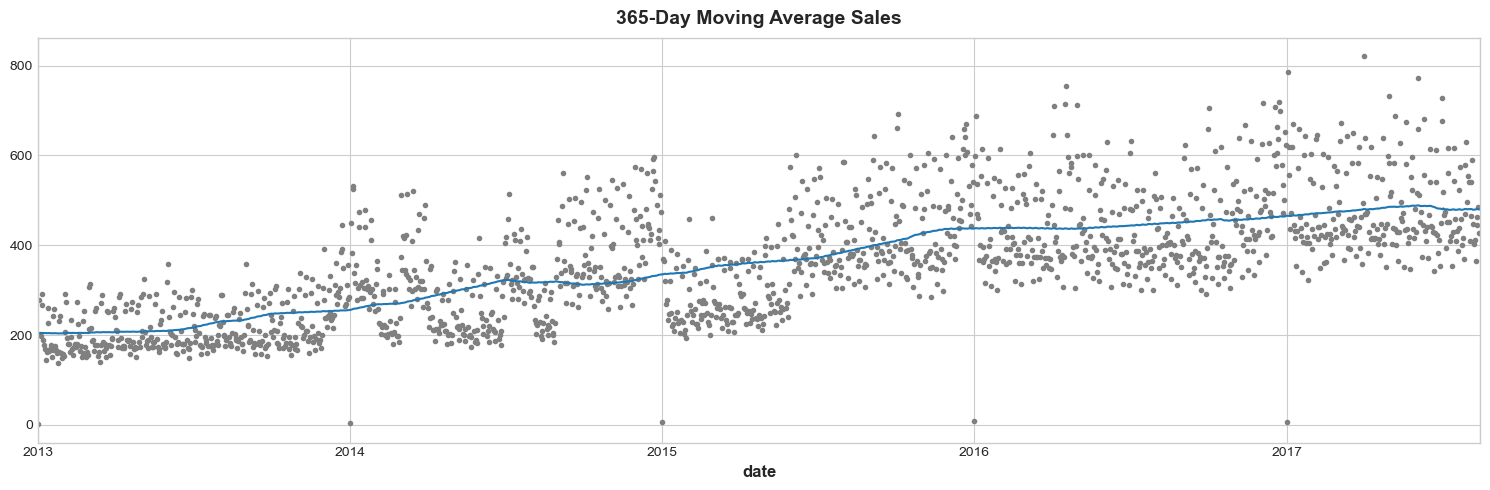

In [7]:
moving_avg = avg_sales.rolling(
    window=365,
    center=True,
    min_periods=183
).mean()

plt.subplots(figsize=(15,5))
ax = avg_sales.plot(style='.', color='0.5')
moving_avg.plot(ax=ax)
ax.set_title('365-Day Moving Average Sales')

## Trend Plot

Text(0.5, 1.0, 'Trend of Total Sales')

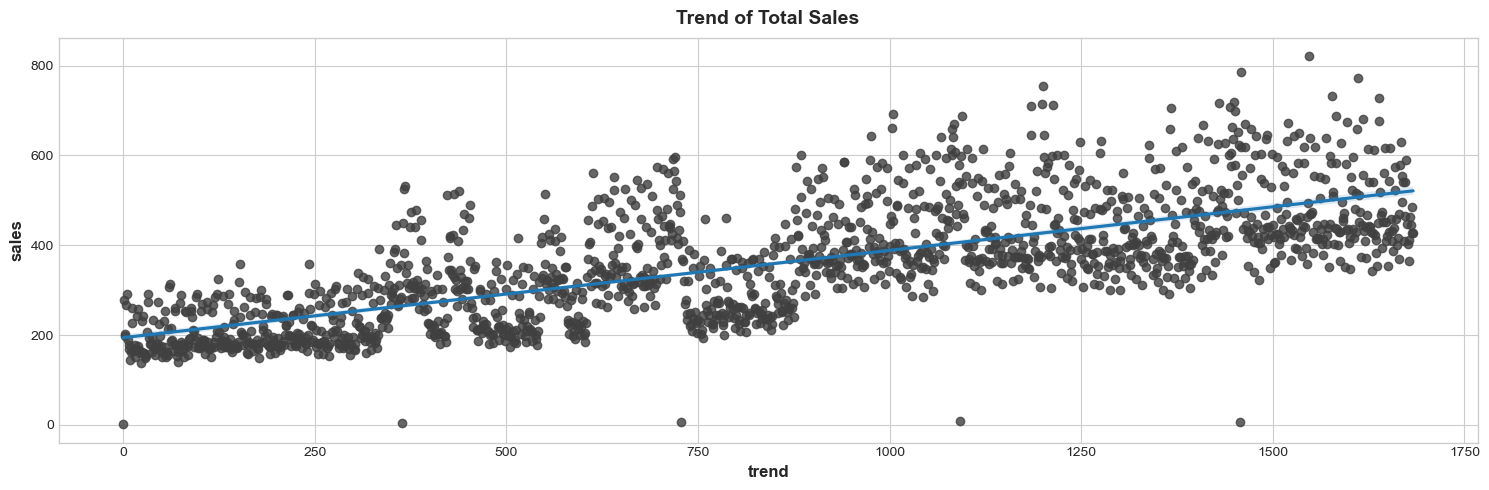

In [130]:
avg_sales_eda = avg_sales.to_frame()
avg_sales_eda['trend'] = np.arange(len(avg_sales))

fig,ax = plt.subplots(figsize=(15,5))
sns.regplot(x='trend', y='sales', data=avg_sales_eda, scatter_kws=dict(color='0.25'))
ax.set_title('Trend of Total Sales')

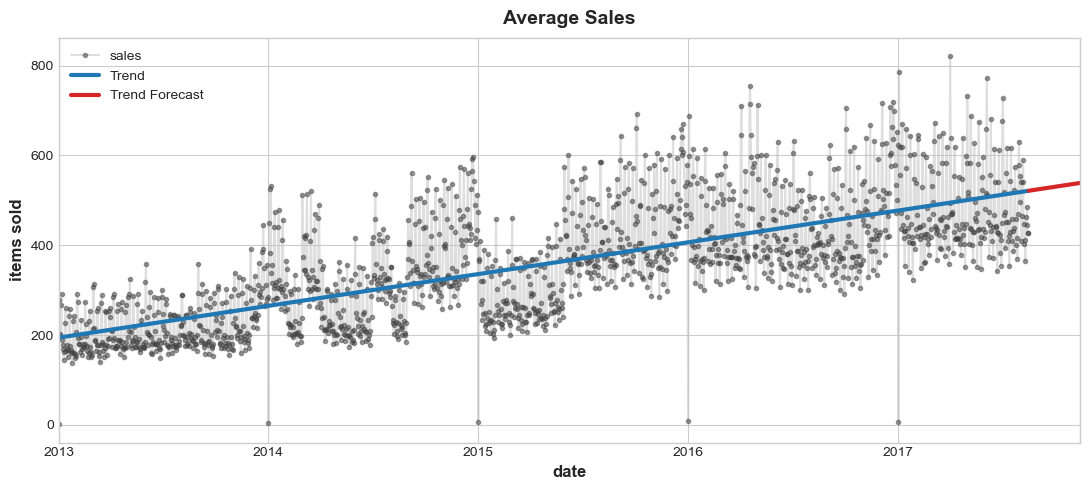

In [135]:
dp = DeterministicProcess(
    index=avg_sales_eda.index,
    order=1,
    drop=True
)
X, X_fore = dp.in_sample(), dp.out_of_sample(steps=90)
y = avg_sales_eda.sales

lr = LinearRegression()
lr.fit(X, y)

y_pred = pd.Series(lr.predict(X), index=X.index)
y_fore = pd.Series(lr.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

## Seasonal Plot

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

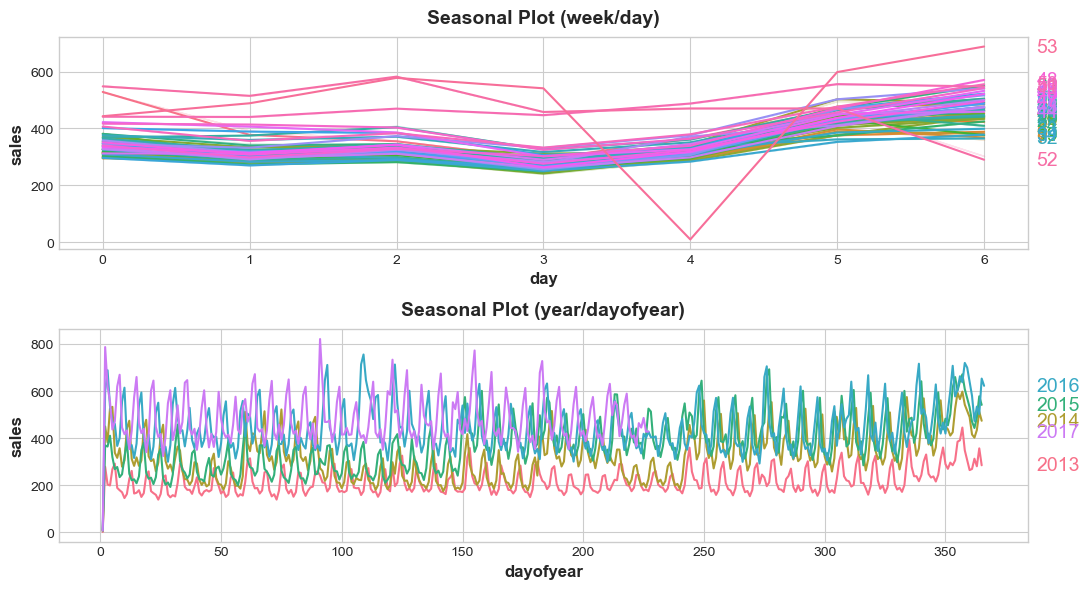

In [91]:
avg_sales_eda = avg_sales.to_frame()
avg_sales_eda['day'] = avg_sales_eda.index.day_of_week
avg_sales_eda['week'] = avg_sales_eda.index.week
avg_sales_eda['dayofyear'] = avg_sales_eda.index.day_of_year
avg_sales_eda['year'] = avg_sales_eda.index.year

# avg_sales = avg_sales.loc['2017']
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(avg_sales_eda, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(avg_sales_eda, y="sales", period="year", freq="dayofyear", ax=ax1)

## Periodogram

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

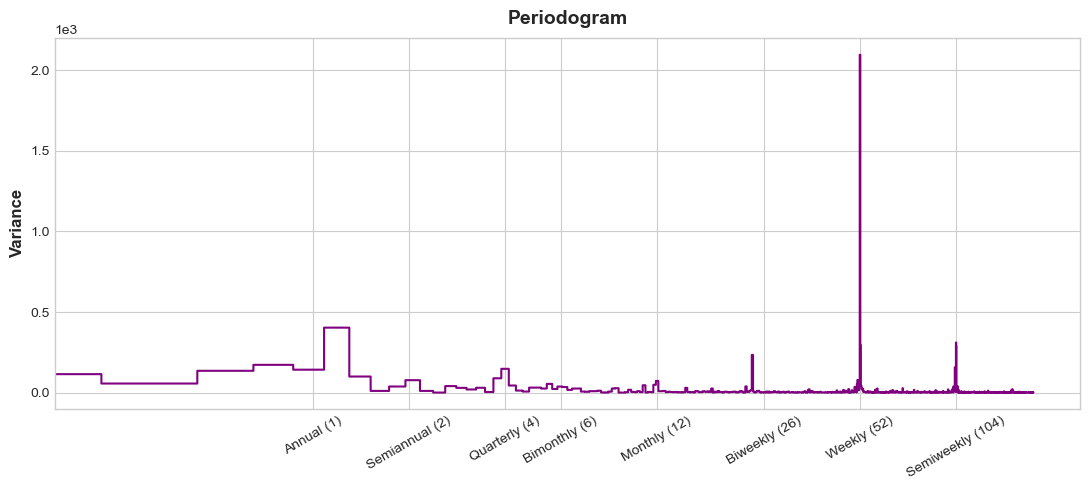

In [139]:
plot_periodogram(avg_sales)

As we can see, moving average plot and trend plot confirm the linear relationship of time and total sales; seasonal plot and periodogram show a strong a strong weekly season and a weaker annualy season. Therefore:
- For trend feature, we will use linear method (order=1).
- For season features, we will use indicators for weekly season and fourier features with 4 pairs for annualy season.

# BUILDING MODEL FOR TIME DEPENDENCE

In [61]:
## Create dataset
fourier = CalendarFourier(freq='A', order=4)
dp = DeterministicProcess(
    index=avg_sales.index,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()

## Add days of new year
X['NewYear'] = (X.index.dayofyear == 1)

y = avg_sales

## View dataset
X.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)",NewYear
date,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2013-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,False
2013-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,False
2013-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,False
2013-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,False


In [82]:
def train_model(X, y, off_holidays=True):
    if not off_holidays:
        ## Add holidays
        X_holidays = pd.get_dummies(holidays)
        X = X.join(X_holidays, on='date').fillna(0)
        X = X.groupby('date').sum()
        X = X.apply(lambda x: x.astype(float), axis=1)
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=90, shuffle=False, random_state=29)
    ## Predict trend

    X_train_trend = X_train[['trend','NewYear']]

    lr = LinearRegression()
    lr.fit(X_train_trend, y_train)

    y_pred_trend = pd.Series(lr.predict(X_train_trend), index=X_train.index)
    X_train_remain = X_train.drop(['trend','NewYear'], axis=1)
    y_train_remain = y_train - y_pred_trend

    xgb = XGBRegressor()
    xgb.fit(X_train_remain, y_train_remain)
    y_pred_remain = pd.Series(xgb.predict(X_train_remain),  index=X_train_remain.index)

    y_pred = y_pred_trend + y_pred_remain

    X_val_trend = X_val[['trend','NewYear']]
    X_val_remain = X_val.drop(['trend','NewYear'], axis=1)

    y_fore = pd.Series(lr.predict(X_val_trend) + xgb.predict(X_val_remain) , index=X_val.index)

    return y_train, y_val, y_pred, y_fore

RMSE: 86.6331


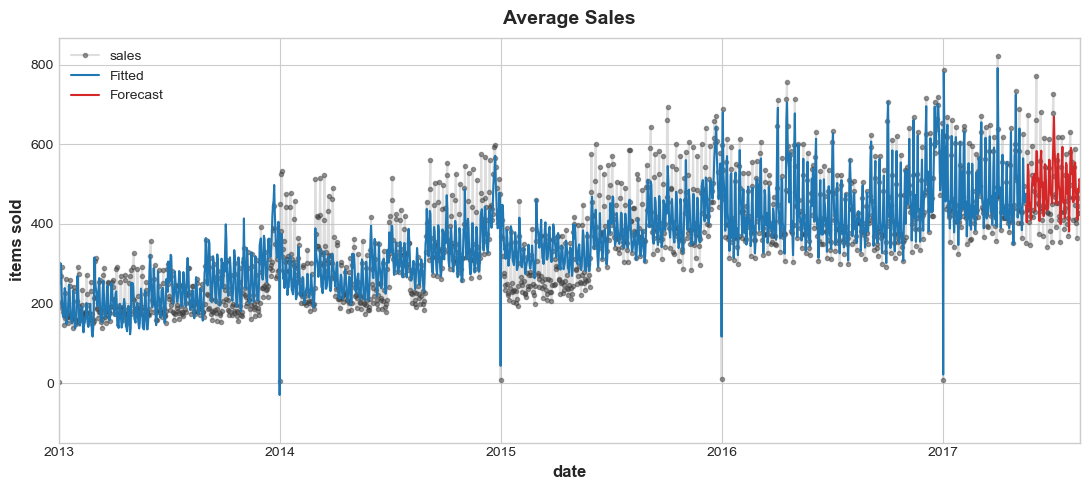

In [83]:
y_train, y_val, y_pred, y_fore = train_model(X, y)
print('RMSE: %.4f' % mean_squared_error(y_val, y_fore, squared=False))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Fitted", color='C0')
ax = y_fore.plot(ax=ax, label="Forecast", color='C3')
ax.legend()

RMSE: 90.1358


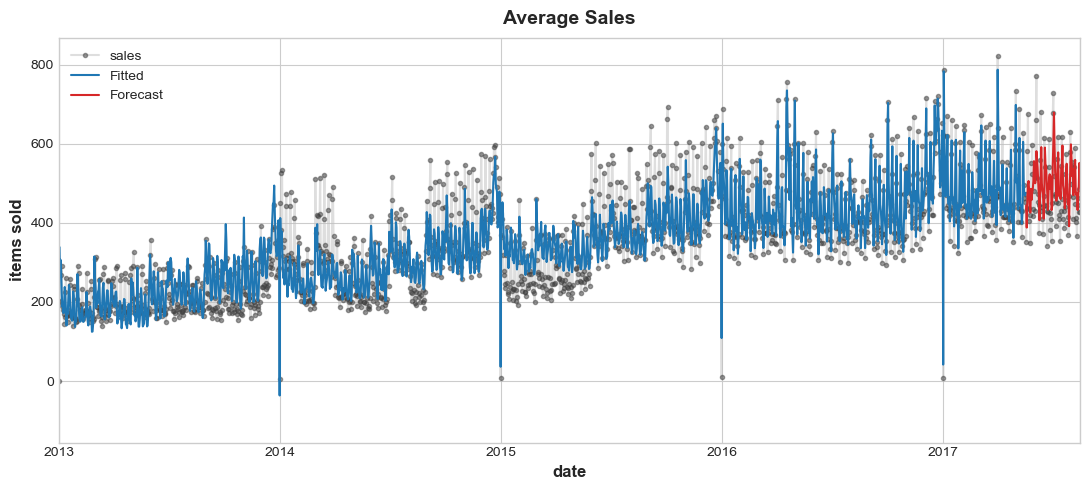

In [84]:
y_train, y_val, y_pred, y_fore = train_model(X, y, off_holidays=False)
print('RMSE: %.4f' % mean_squared_error(y_val, y_fore, squared=False))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Fitted", color='C0')
ax = y_fore.plot(ax=ax, label="Forecast", color='C3')
ax.legend()

# EDA for Serial Dependence

Text(0.5, 1.0, 'Deseasonalized')

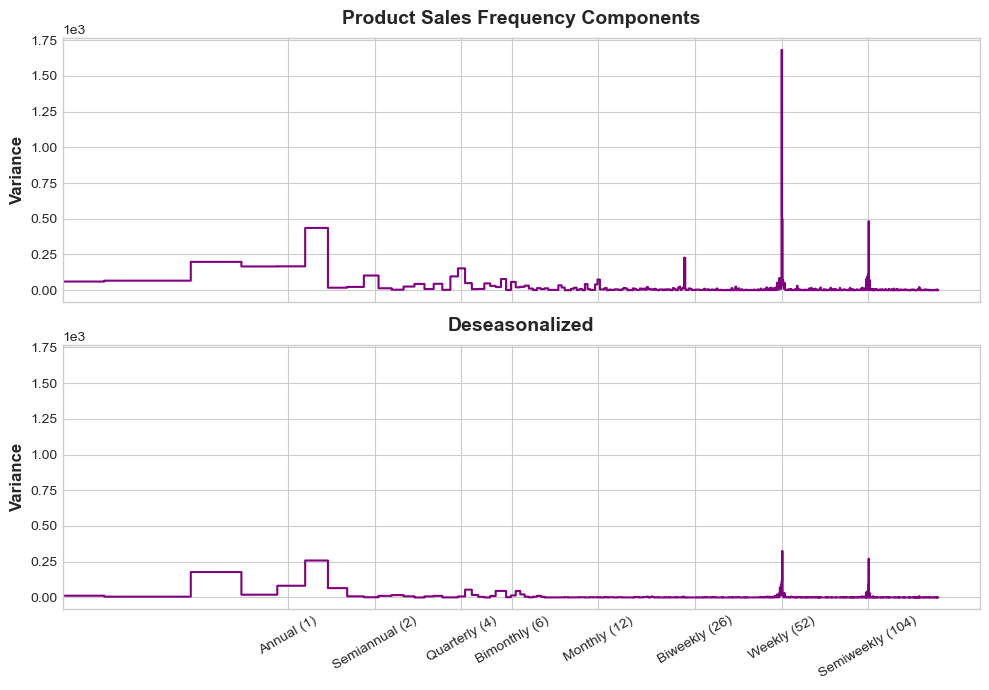

In [101]:
## Deseasionalize

y_train_deseason = y_train - y_pred
y_val_deseason = y_val - y_fore

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_train, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_train_deseason, ax=ax2)
ax2.set_title("Deseasonalized")

Text(0.5, 1.0, 'Sales of School and Office Supplies (deseasonalized)')

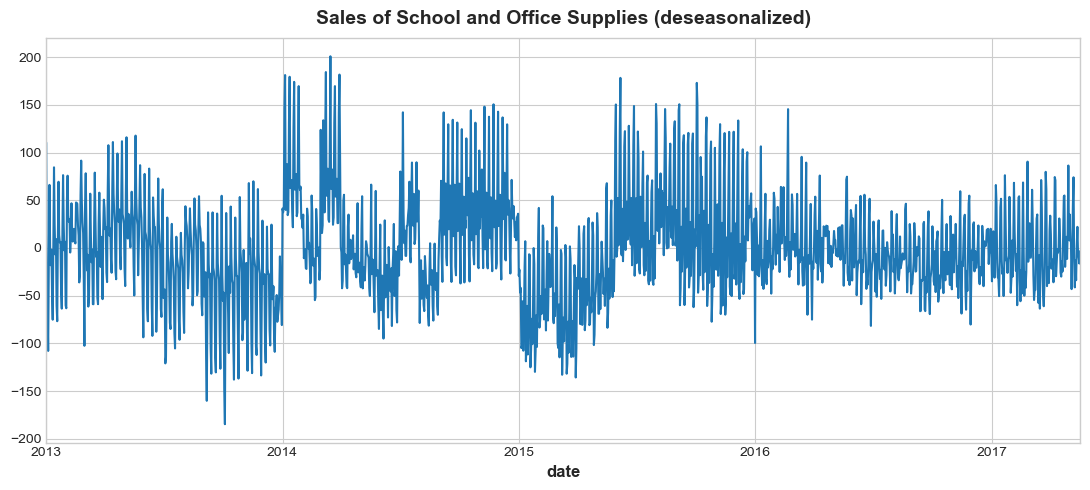

In [86]:
ax = y_train_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)")

To confirm our intuition of cyclic patterns, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

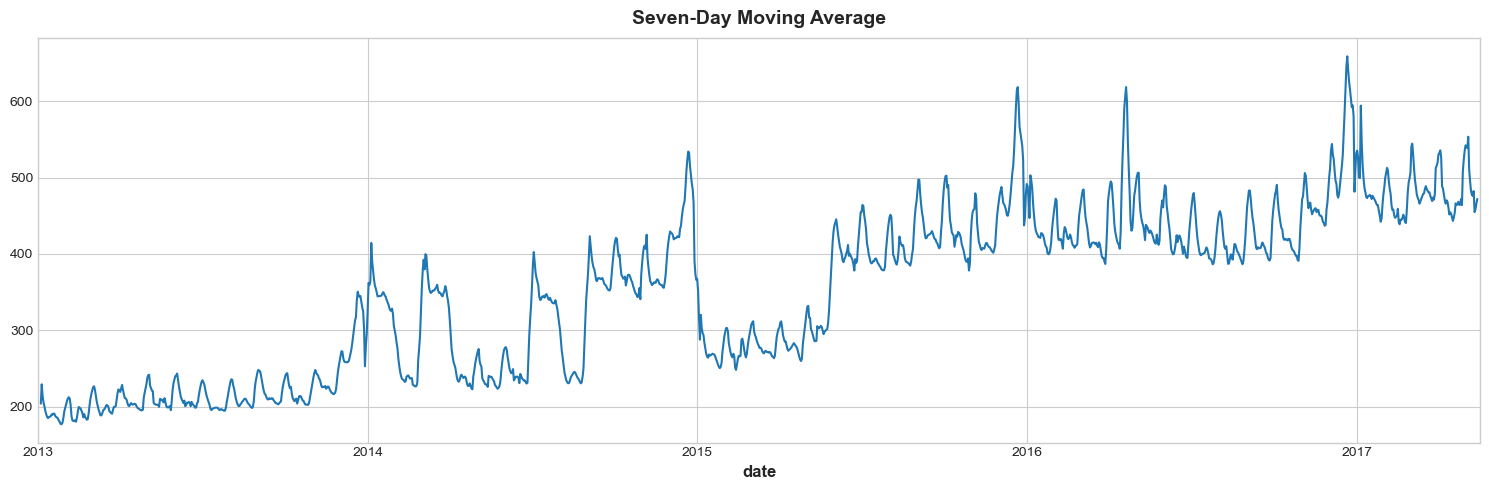

In [78]:
plt.figure(figsize=(15,5))
y_ma = y_train.rolling(
    window=7,
    center=True
).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

In [79]:
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

We can see how the moving average plot resembles the plot of the deseasonalized series. In both, we can see cyclic behavior indicated.

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

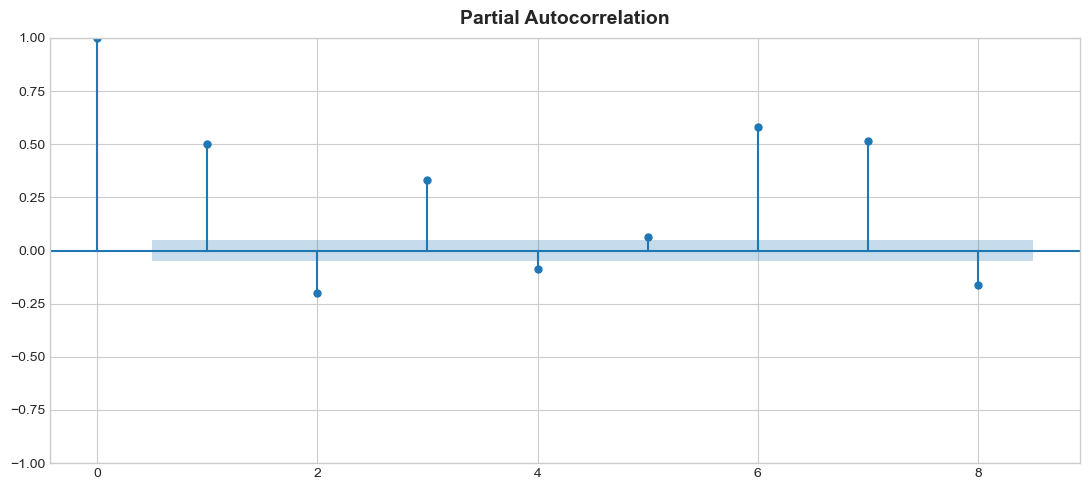

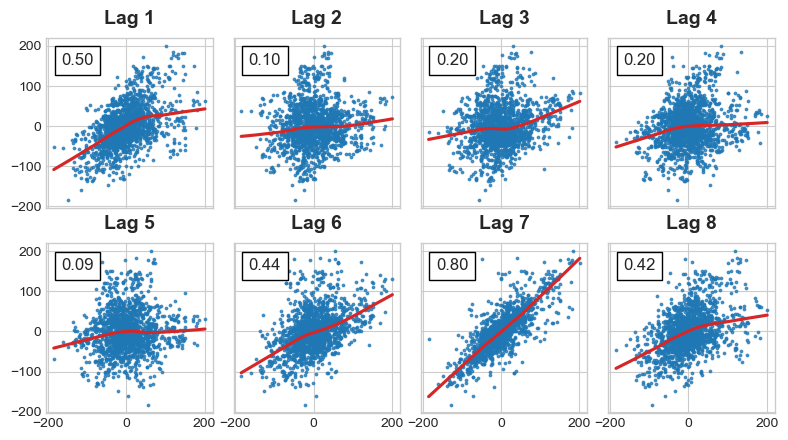

In [119]:
plot_pacf(y_train_deseason, lags=8)
plot_lags(y_train_deseason, lags=8, nrows=2)

The correlogram indicates most of lags tend to be significant but weak correlation, except for the seventh lag. The lag plot also suggests the effect of seventh lag is mostly linear.

RMSE: 55.0316


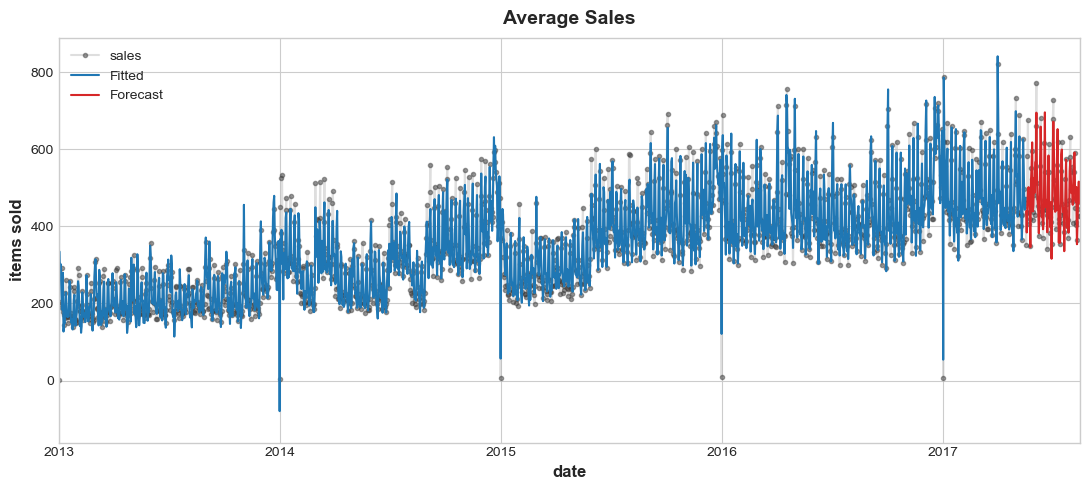

In [102]:
X_train_deseason = y_train_deseason.shift(7).fillna(0)

xgb = XGBRegressor()
xgb.fit(X_train_deseason, y_train_deseason)

y_pred_deseason = pd.Series(xgb.predict(X_train_deseason), index=X_train_deseason.index)

X_val_deseason = y_val_deseason.shift(7).fillna(0)
y_fore_deseason = pd.Series(xgb.predict(X_val_deseason), index=X_val_deseason.index)

y_pred_all = y_pred + y_pred_deseason
y_fore_all = y_fore + y_fore_deseason

print('RMSE: %.4f' % mean_squared_error(y_val, y_fore_all, squared=False))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred_all.plot(ax=ax, label="Fitted", color='C0')
ax = y_fore_all.plot(ax=ax, label="Forecast", color='C3')
ax.legend()
